### Import Python packages


In [1]:
import macrosynergy
import pandas as pd
import numpy as np
import polars as pl
import os

from macrosynergy.panel import view_timelines
from macrosynergy.management.types import QuantamentalDataFrame


### Import Python bindings - `msyrs`


In [2]:
import msyrs

In [3]:
DATA_FOLDER_PATH = "E:/Work/jpmaqs-data"
# DATA_FOLDER_PATH = "C:/Users/PalashTyagi/Code/go-dataquery/jpmaqs-data"
DQ_CLIENT_ID = os.getenv("DQ_CLIENT_ID")
DQ_CLIENT_SECRET = os.getenv("DQ_CLIENT_SECRET")

In [4]:
import time

nb_start_time = time.time()

In [5]:
dfpath = f"{DATA_FOLDER_PATH}/data/ADPEMPL_SA_P1M1ML1/USD_ADPEMPL_SA_P1M1ML1.csv"

starttime = time.time()
ldf: pl.DataFrame = msyrs.qdf.load_qdf(dfpath)
print(f"Time taken to load qdf: {time.time() - starttime}")
ldf.head(5)

Time taken to load qdf: 0.0


shape: (5, 7)
┌────────────┬─────┬────────────────────┬───────────┬─────────┬─────────┬─────────┐
│ real_date  ┆ cid ┆ xcat               ┆ value     ┆ grading ┆ eop_lag ┆ mop_lag │
│ ---        ┆ --- ┆ ---                ┆ ---       ┆ ---     ┆ ---     ┆ ---     │
│ date       ┆ str ┆ str                ┆ f64       ┆ f64     ┆ i64     ┆ i64     │
╞════════════╪═════╪════════════════════╪═══════════╪═════════╪═════════╪═════════╡
│ 2010-03-03 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 3       ┆ 33      │
│ 2010-03-04 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 4       ┆ 34      │
│ 2010-03-05 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 5       ┆ 35      │
│ 2010-03-08 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 8       ┆ 38      │
│ 2010-03-09 ┆ USD ┆ ADPEMPL_SA_P1M1ML1 ┆ -0.173806 ┆ 3.0     ┆ 9       ┆ 39      │
└────────────┴─────┴────────────────────┴───────────┴─────────┴─────────┴─────────┘

In [6]:
cids_dm = "AUD.CAD.CHF.EUR.GBP.JPY.NOK.NZD.SEK.USD".split(".")
cids_em = "CLP.COP.CZK.HUF.IDR.ILS.INR.KRW.MXN.PLN.THB.TRY.TWD.ZAR".split(".")
cids = cids_dm + cids_em
cids_dux = list(set(cids) - set(["IDR", "NZD"]))
ecos = "CPIC_SA_P1M1ML12.CPIC_SJA_P3M3ML3AR.CPIC_SJA_P6M6ML6AR.CPIH_SA_P1M1ML12.CPIH_SJA_P3M3ML3AR.CPIH_SJA_P6M6ML6AR.INFTEFF_NSA.INTRGDP_NSA_P1M1ML12_3MMA.INTRGDPv5Y_NSA_P1M1ML12_3MMA.PCREDITGDP_SJA_D1M1ML12.RGDP_SA_P1Q1QL4_20QMA.RYLDIRS02Y_NSA.RYLDIRS05Y_NSA.PCREDITBN_SJA_P1M1ML12".split(
    "."
)


mkts = "DU02YXR_NSA.DU05YXR_NSA.DU02YXR_VT10.DU05YXR_VT10.EQXR_NSA.EQXR_VT10.FXXR_NSA.FXXR_VT10.FXCRR_NSA.FXTARGETED_NSA.FXUNTRADABLE_NSA".split(
    "."
)
xcats = ecos + mkts

tickers = [f"{c}_{x}" for c in cids for x in xcats]

In [7]:
starttime = time.time()

big_df: pl.DataFrame = msyrs.qdf.load_qdf_from_download_bank(
    folder_path=DATA_FOLDER_PATH,
    xcats=xcats,
)
print(f"Time taken to load qdf batch: {time.time() - starttime}")


Time taken to load qdf batch: 1.3091998100280762


In [8]:
big_df.estimated_size("mb")

286.69339656829834

In [9]:
sel_cids = ["USD", "EUR", "GBP", "AUD", "CAD"]
start = "1990-01-01"

In [10]:
fx_xcats = [xc for xc in xcats if xc.startswith("FX")]
eq_xcats = [xc for xc in xcats if xc.startswith("EQ")]
starttime = time.time()

eq_df = msyrs.qdf.reduce_dataframe(
    df=big_df,
    cids=sel_cids,
    xcats=fx_xcats + eq_xcats,
    start=start,
)

fx_df = msyrs.qdf.reduce_dataframe(
    df=big_df, cids=sel_cids, start=start, xcats=fx_xcats, intersect=True
)
new_df: pl.DataFrame = msyrs.qdf.update_dataframe(df=eq_df, df_add=fx_df)

print(f"Time taken to reduce qdf: {time.time() - starttime}")


Time taken to reduce qdf: 0.809798002243042


In [11]:
# df: polars::prelude::DataFrame,
# xcat: String,
# cids: Option<Vec<String>>,
# lback_periods: Option<usize>,
# lback_method: Option<String>,
# half_life: Option<f64>,
# start: Option<String>,
# end: Option<String>,
# est_freq: Option<String>,
# remove_zeros: Option<bool>,
# postfix: Option<String>,
# nan_tolerance: Option<f64>,

starttime = time.time()
hv = msyrs.panel.historic_vol(
    df=new_df,
    xcat="EQXR_NSA",
    cids=None,
    lback_periods=21,
    lback_method="xma",
    half_life=11,
    start=None,
    end=None,
    est_freq="D",
    remove_zeros=None,
    postfix="_HV_RS",
    nan_tolerance=None,
)
print(f"Time taken: {time.time() - starttime}")

starttime = time.time()
a = 1 + 5
print("Time taken: ", time.time() - starttime)


Time taken: 0.3569352626800537
Time taken:  0.0


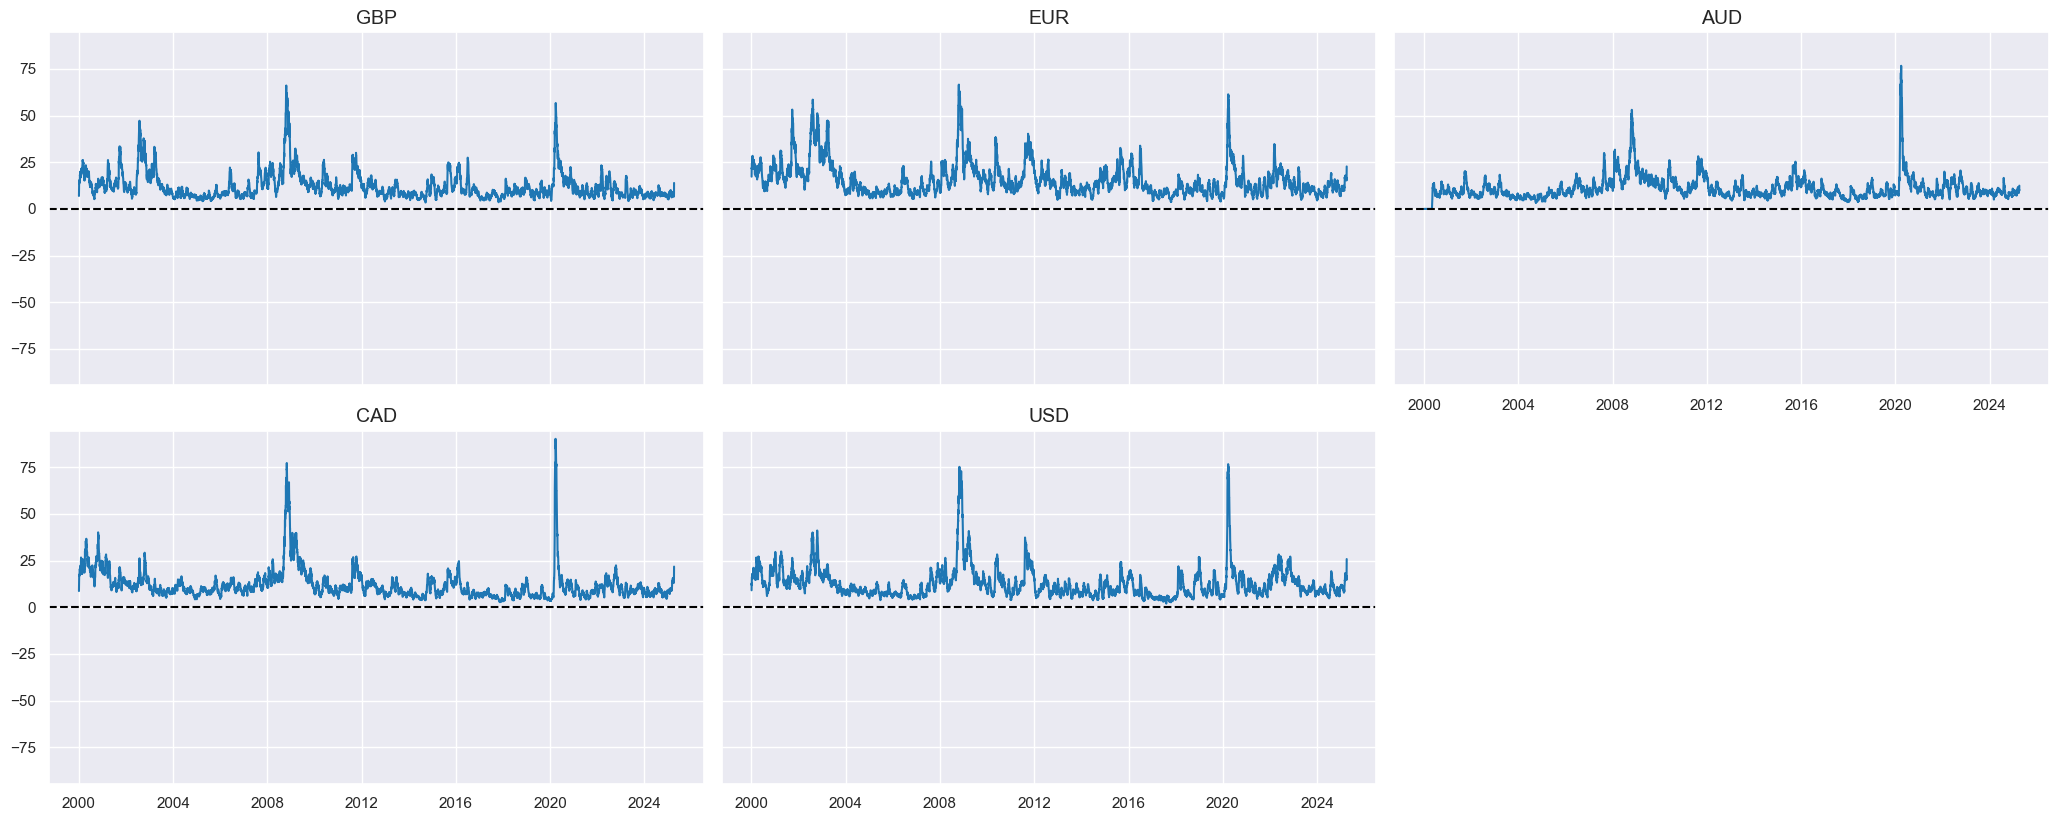

In [12]:

hdf = hv.to_pandas()

hdf = QuantamentalDataFrame.from_wide(
    (
        
        QuantamentalDataFrame(hdf)
        .to_wide()
        .reindex(
            pd.bdate_range(
                start=hdf["real_date"].min(),
                end=hdf["real_date"].max(),
                freq="B",
            ),
            method="ffill",
        )
        .dropna(axis="rows", how="all")
    ).sort_index(),
    categorical=False,
)

view_timelines(df=hdf)



In [13]:
from macrosynergy.panel.historic_vol import historic_vol

new_df_pd = QuantamentalDataFrame(
    new_df.to_pandas(), categorical=False
)
cids = new_df_pd['cid'].unique().tolist()

starttime = time.time()
hv_bench = historic_vol(
    df=new_df_pd,
    xcat='EQXR_NSA',
    cids=cids,
    lback_periods=21,
    lback_meth="xma",
    half_life=11,
    est_freq="D",
    blacklist=None,
    remove_zeros=True,
    postfix="_HV_PY",
    nan_tolerance=0.001,
)
print(f"Time taken: {time.time() - starttime}")

starttime = time.time()
a = 1 + 5
print("Time taken: ", time.time() - starttime)

Time taken: 15.248189926147461
Time taken:  0.0


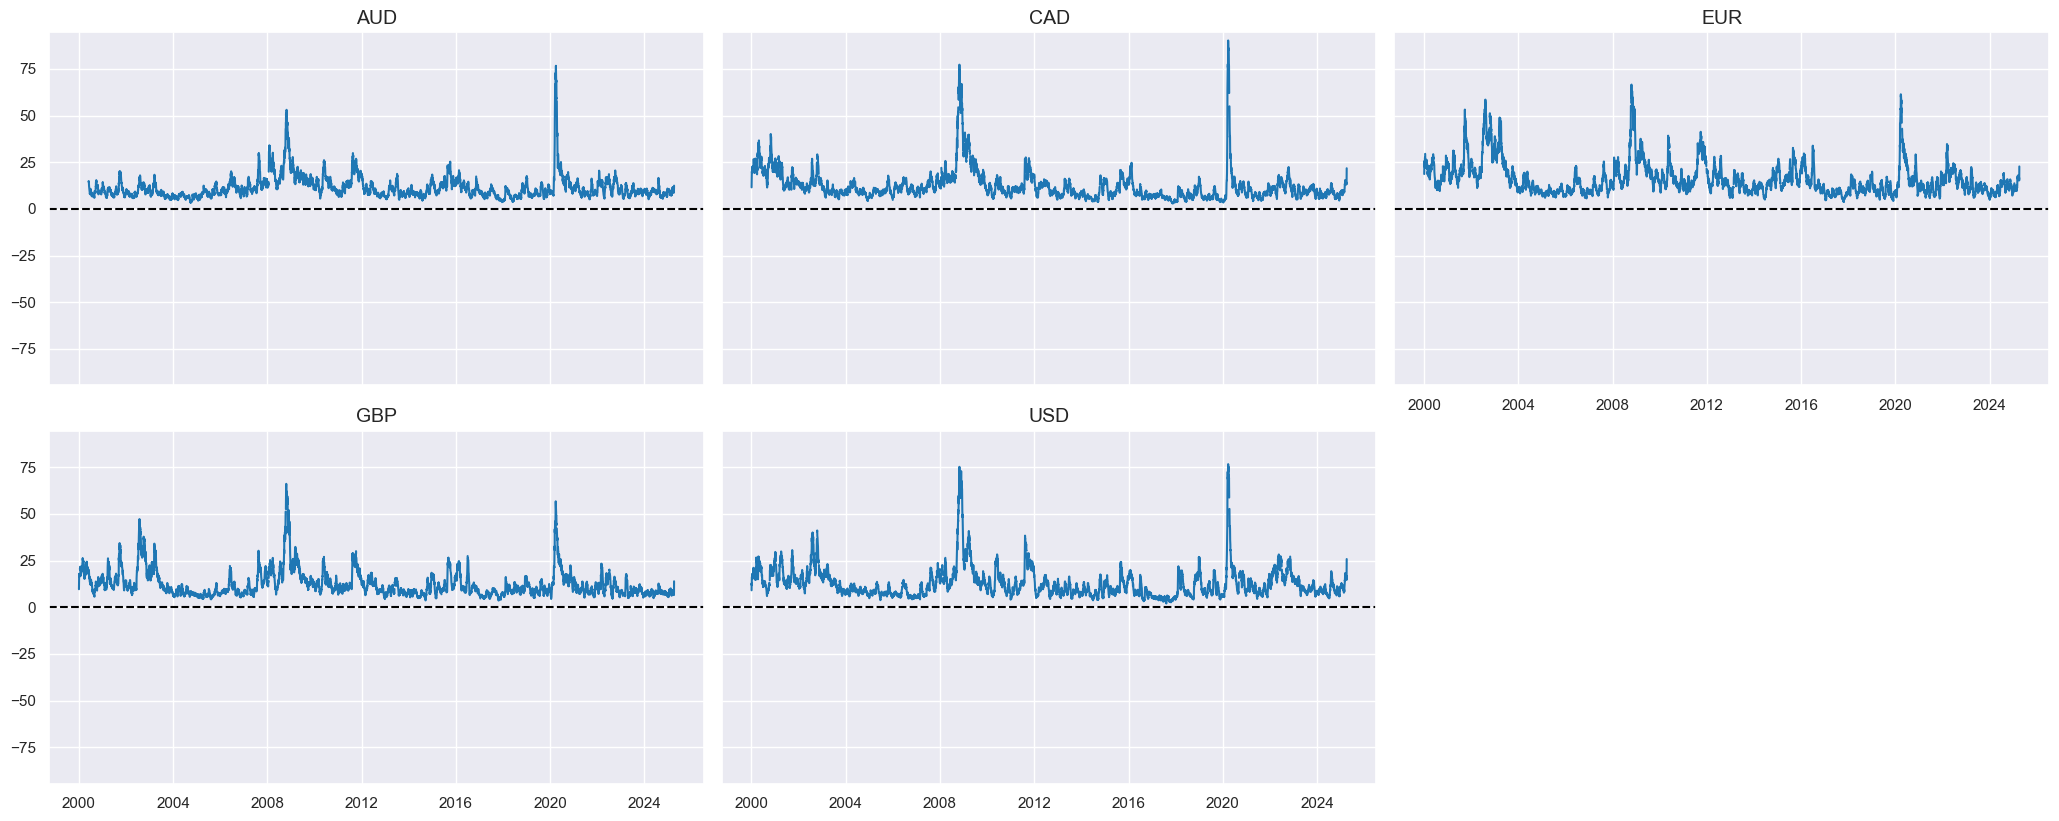

In [14]:
view_timelines(df=hv_bench)

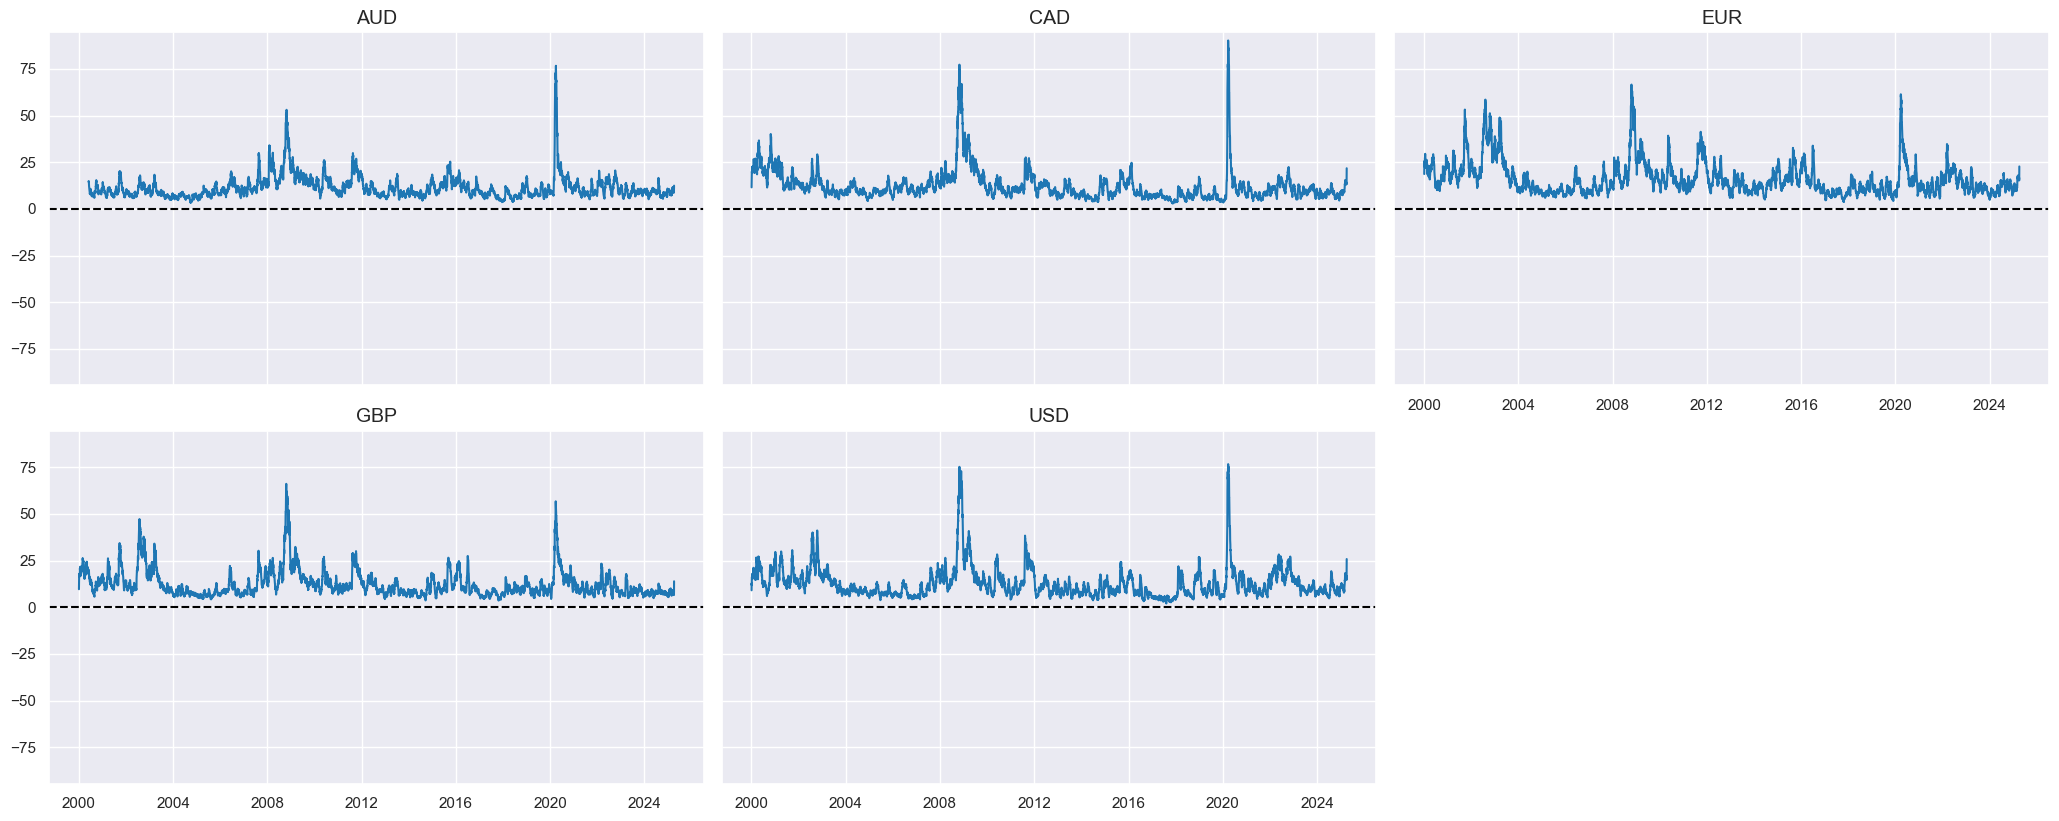

In [15]:
hv_bench = hv_bench.dropna(axis="rows", how="any").reset_index(drop=True)
bdr = pd.bdate_range(new_df_pd.real_date.min(), new_df_pd.real_date.max())
hv_bench = QuantamentalDataFrame.from_wide(
    QuantamentalDataFrame(hv_bench).to_wide().reindex(bdr, method="ffill"),
    categorical=False,
).reset_index(drop=True)

view_timelines(df=hv_bench)

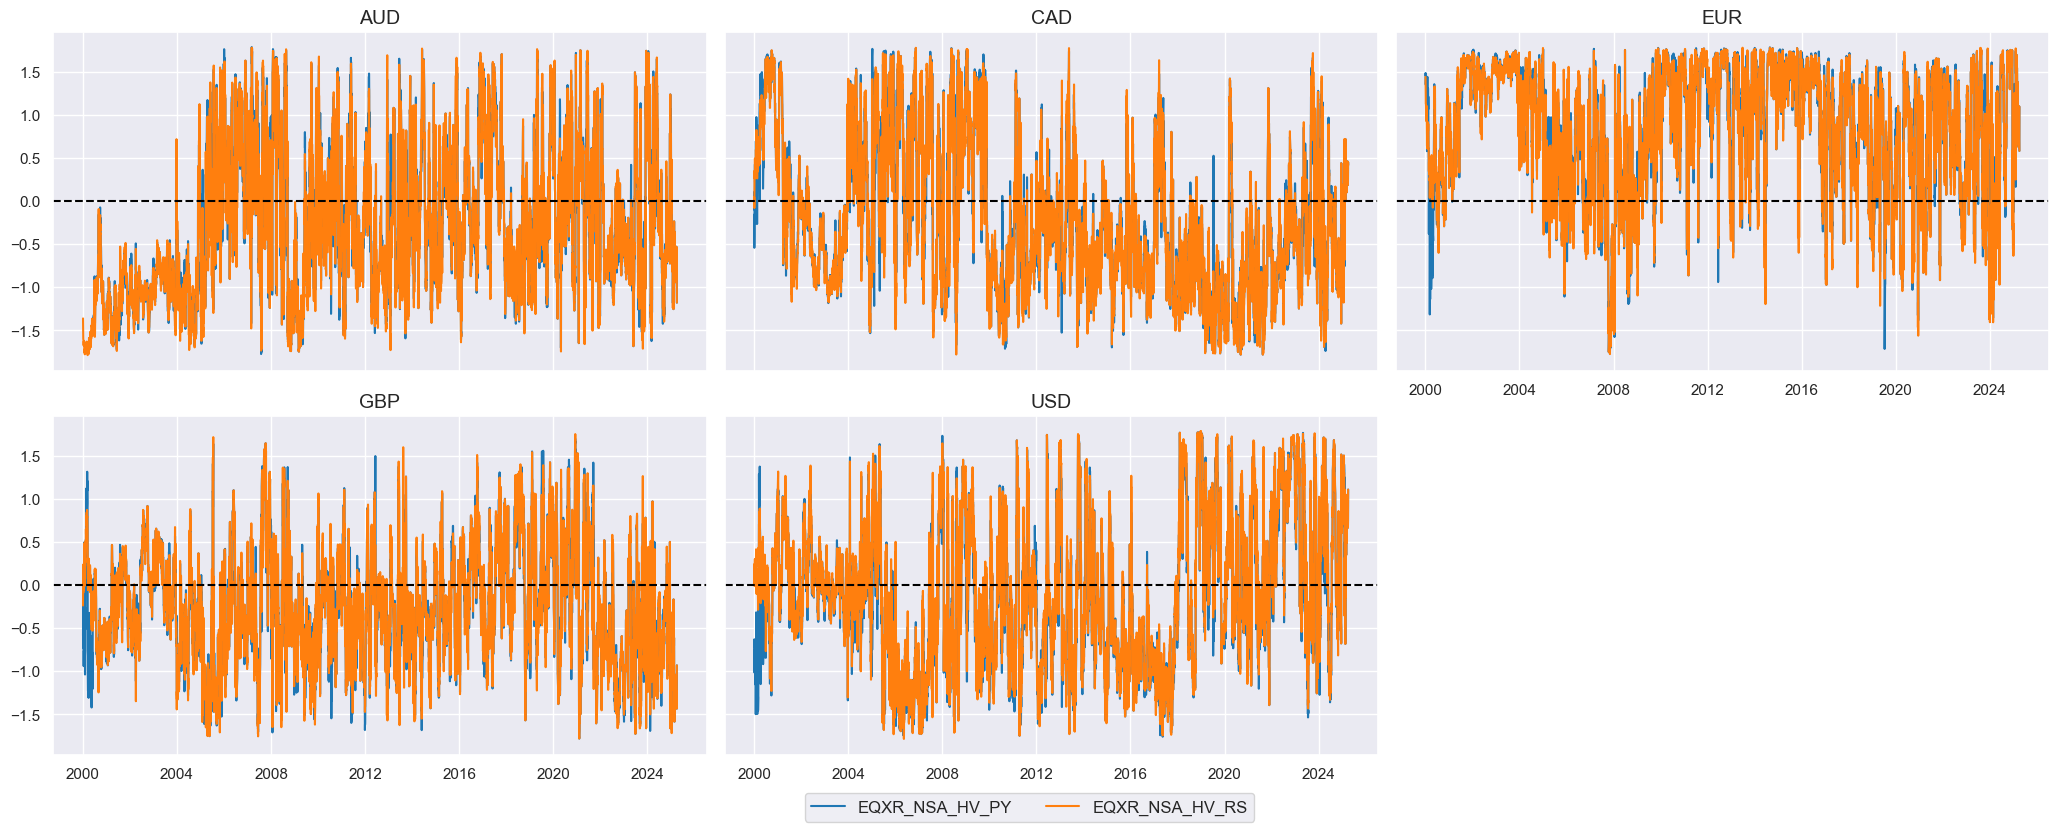

In [16]:
def zscore_series(s: pd.Series) -> pd.Series:
    return (s - s.mean()) / s.std()


a = QuantamentalDataFrame.from_wide(
    QuantamentalDataFrame(hv_bench)
    .to_wide()
    .apply(lambda x: zscore_series(x), axis=1, result_type="expand")
)

b = QuantamentalDataFrame.from_wide(
    QuantamentalDataFrame(hdf)
    .to_wide()
    .apply(lambda x: zscore_series(x), axis=1, result_type="expand")
)

view_timelines(QuantamentalDataFrame.from_qdf_list([a, b]).dropna(axis="rows", how="any").reset_index(drop=True))


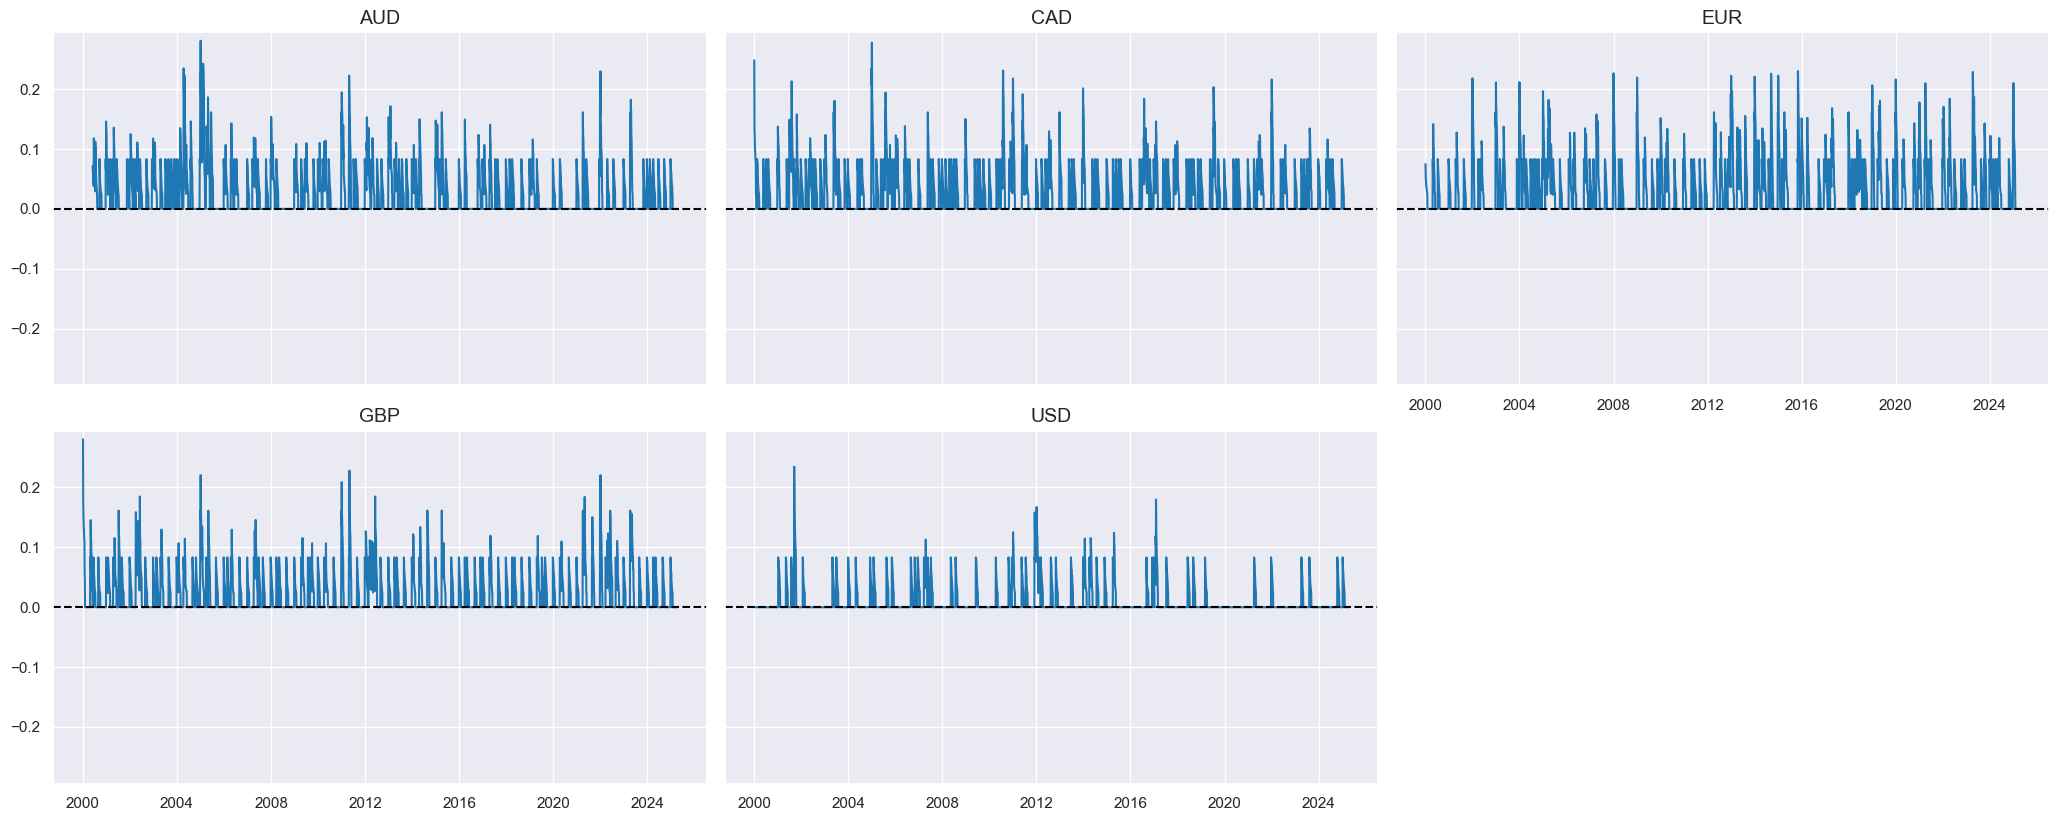

In [20]:
# a = QuantamentalDataFrame(hv_bench).to_wide().apply(lambda x: zscore_series(x), axis=1, result_type="expand").rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

# b = QuantamentalDataFrame(hdf).to_wide().apply(lambda x: zscore_series(x), axis=1, result_type="expand").rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

a = QuantamentalDataFrame(hv_bench).to_wide().rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

b = QuantamentalDataFrame(hdf).to_wide().rename(columns=lambda x: '_'.join(x.split("_")[:-1]))

diff = (a.abs() - b.abs()).abs() / (a.abs())

view_timelines(QuantamentalDataFrame.from_wide(diff))

In [18]:
end_time = time.time()
print(f"Time taken: {end_time - nb_start_time} seconds")

Time taken: 21.97717595100403 seconds
